In [378]:
import numpy as np
from scipy.stats.mstats import mode
from copy import deepcopy
import pandas as pd
import time
from helper import *
%matplotlib inline

In [2]:
train_np = np.loadtxt('data/train.txt', delimiter=',', skiprows=1)
train_np.shape

(43200, 57)

In [3]:
# Most frequent values for each sensor
mode(train).mode.data

NameError: name 'train' is not defined

In [273]:
df_train = pd.read_csv('data/train.txt', skipinitialspace=True)
df_test = pd.read_csv('data/test.txt', skipinitialspace=True)
df_train.rename(columns={'Timestamp (DHHMM)':'time'}, inplace=True)
df_test.keys()

Index([u'Sensor ID', u'Start Time', u'End Time', u'People Count'], dtype='object')

In [301]:
# #### To build a submission file
df_train_current = df_train_day_avg
submission_name = 'day_avg_v1.csv'

def timestamptoindex(ts):
    mm = ts % 100
    hh = (ts % (100 * 100)) // 100
    d = ts // (100 * 100)
    
    index = mm + 60 * hh + 60 * 24 * (d - 1)
    return index

def get_count(row, train):
    start = int(row['Start Time'])
    end = int(row['End Time'])
    col = row['Sensor ID']
    i0 = timestamptoindex(start)
    i1 = timestamptoindex(end)
    
    cum_sum = train[col][i0:i1].sum()
    return cum_sum

df_test['Count'] = df_test.apply(lambda row: get_count(row, df_train_current),axis=1)

# Saving it under the name submission_name
df_test['Index'] = df_test.index + 1
df_test[['Index', 'Count']].to_csv(submission_name, index=False)

In [134]:
df_test.head()

,Sensor ID,Start Time,End Time,People Count
0,S9,11100,11159,-59
1,S26,11100,11159,-59
2,S48,11100,11159,-59
3,S9,11200,11259,-59
4,S26,11200,11259,-59


In [72]:
test[['Index', 'Count']].to_csv('dummy.csv', index=False)

In [8]:
df_train.head()

,time,S1,S2,S3,S4,S5,S6,S7,S8,S9,...,S47,S48,S49,S50,S51,S52,S53,S54,S55,S56
0,10000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,10001,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,10002,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,10003,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,10004,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


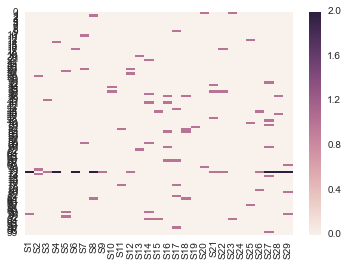

In [53]:
import seaborn as sns
df = df_train[['S'+str(i) for i in xrange(1, 30)]][:100]

sns.heatmap(df)

In [54]:
# Nearest neighbors model
adjacency_list = {
    1: [2, 4, 35],
    2: [1, 34, 35, 36, 41],
    3: [4, 8],
    4: [1, 3],
    5: [7, 45],
    6: [8, 12],
    7: [5, 55],
    8: [3, 6],
    9: [12, 44],
    10: [11, 55],
    11: [10, 13],
    12: [6, 9],
    13: [11, 39],
    14: [16, 54],
    15: [14, 16],
    16: [14, 15, 17],
    17: [16, 56],
    18: [19, 56],
    19: [18, 20],
    20: [19, 21],
    21: [20, 22, 23],
    22: [21, 23, 43],
    23: [21, 24],
    24: [23, 25],
    25: [24, 26],
    26: [25, 27],
    27: [26, 28, 29],
    28: [27, 47],
    29: [27, 30],
    30: [29, 31],
    31: [30, 32],
    32: [31, 33],
    33: [32, 34, 35],
    34: [2, 33, 35, 36, 41],
    35: [1, 2, 34, 36, 41],
    36: [2, 34, 35, 41],
    37: [36, 38],
    38: [37, 40],
    39: [13, 43],
    40: [38],
    41: [2, 36, 42],
    42: [41, 46],
    43: [22, 39],
    44: [9, 45],
    45: [5, 44],
    46: [42],
    47: [28, 48],
    48: [47, 49],
    49: [48, 50],
    50: [49, 51],
    51: [50, 52, 53],
    52: [50, 51, 53],
    53: [51, 52, 54],
    54: [53, 14],
    55: [7, 10],
    56: [17, 18]
}

In [133]:
# Several possibilities to average the result among the neighbors:
#    - cumulative sum of neighbors (v1)
#    - average (truncated) (v2)
#    - average (raw) (v3) --> Best one: 9.22
#    - average (rounded) (v4)
def fill_neighbors(row, col_name, adjacency_list):
    if row[col_name] == -1:
        new_value = 0.
        count = 0
        col_ind = int(col_name[1:])
        for n in adjacency_list[col_ind]:
            if row[n] != -1:
                new_value += row[n]
                count += 1
        if count:
            return round(new_value / (1. * count))
        return new_value
    else:
        return row[col_name]



In [125]:
col_names = ['S'+str(i) for i in xrange(1, 57)]
df_train_neighbors_avg = df_train.copy()

In [134]:
for col_name in col_names:
    start = time.time()
    df_train_neighbors_avg[col_name] = df_train.apply(lambda row: fill_neighbors(row, col_name, adjacency_list),axis=1)
    total_time = time.time() - start
    print 'Col {} computed in {}'.format(col_name, total_time)

Col S1 computed in 2.10306501389
Col S2 computed in 2.03278207779
Col S3 computed in 2.06884407997
Col S4 computed in 2.40533804893
Col S5 computed in 2.20628619194
Col S6 computed in 2.76762294769
Col S7 computed in 2.09706306458
Col S8 computed in 2.02352499962
Col S9 computed in 2.57313513756
Col S10 computed in 2.03930902481
Col S11 computed in 2.00582504272
Col S12 computed in 2.09261488914
Col S13 computed in 2.63840794563
Col S14 computed in 2.64893007278
Col S15 computed in 2.12684106827
Col S16 computed in 1.99684691429
Col S17 computed in 2.40207600594
Col S18 computed in 2.01254200935
Col S19 computed in 2.02449917793
Col S20 computed in 2.66367197037
Col S21 computed in 1.98050689697
Col S22 computed in 2.03429889679
Col S23 computed in 2.53910899162
Col S24 computed in 1.97597718239
Col S25 computed in 1.96993112564
Col S26 computed in 2.46613812447
Col S27 computed in 1.95004200935
Col S28 computed in 2.49723696709
Col S29 computed in 2.96787405014
Col S30 computed in 2.4

In [127]:
# Checking that all the values are filled
cum_sum = 0
for col in col_names:
    cum_sum += len(df_train_neighbors_avg[df_train_neighbors[col] == -1])
print cum_sum

0


In [116]:
df_train_neighbors.head()

,time,S1,S2,S3,S4,S5,S6,S7,S8,S9,...,S47,S48,S49,S50,S51,S52,S53,S54,S55,S56
0,10000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,10001,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,10002,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,10003,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,10004,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [132]:
round(3./5)

1.0

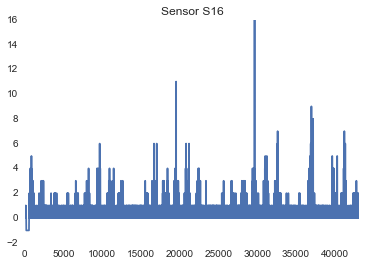

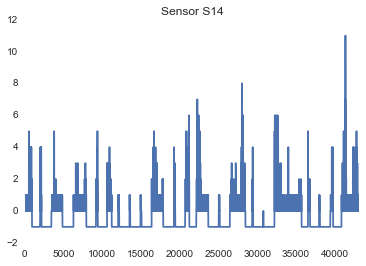

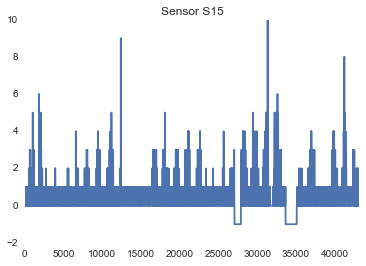

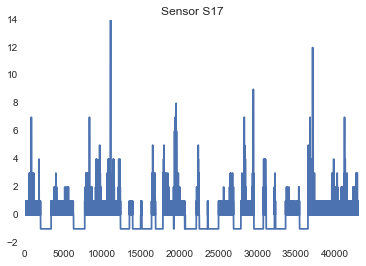

In [154]:
# ### Exploring the time data by sensor (to build feature)

# Large grid (looking for pattern over the days)
col = 'S16'
df_train[col].plot()
plt.title('Sensor {}'.format(col))
plt.show()
for n in adjacency_list[int(col[1:])]:
    n_name = 'S'+str(n)
    df_train[n_name].plot()
    plt.title('Sensor {}'.format(n_name))
    plt.show()

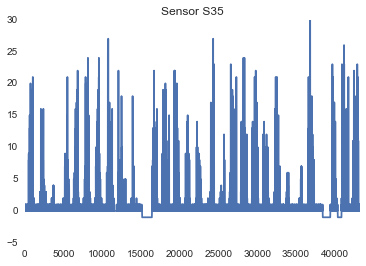

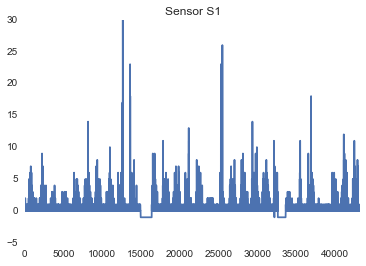

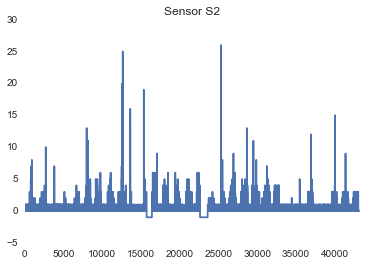

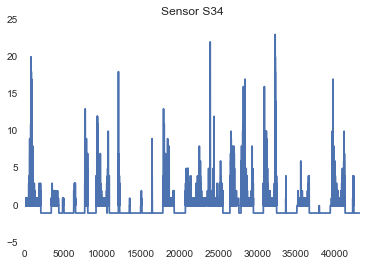

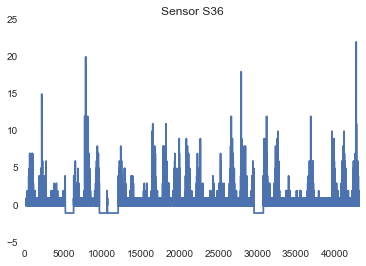

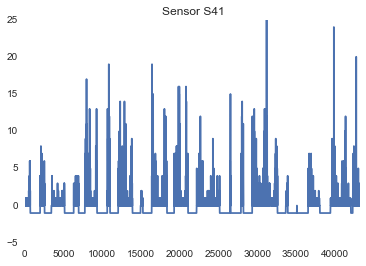

In [153]:
# ### Exploring the time data by sensor (to build feature)
col = 'S35'
df_train[col].plot()
plt.title('Sensor {}'.format(col))
plt.show()
for n in adjacency_list[int(col[1:])]:
    n_name = 'S'+str(n)
    df_train[n_name].plot()
    plt.title('Sensor {}'.format(n_name))
    plt.show()

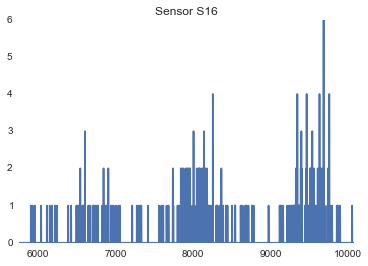

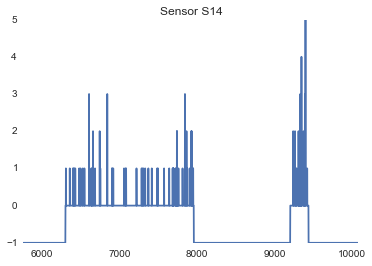

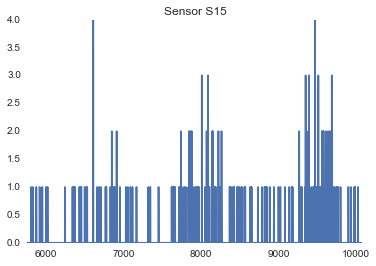

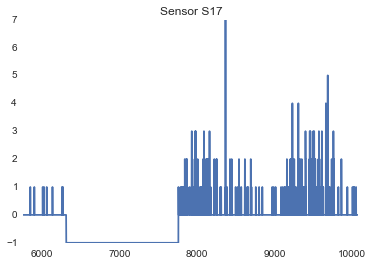

In [158]:
# Finer grid (looking for pattern over the days)
day0 = 4
day1 = 7
col = 'S16'
df_train[col][day0 * 1440:day1*1440].plot()
plt.title('Sensor {}'.format(col))
plt.show()
for n in adjacency_list[int(col[1:])]:
    n_name = 'S'+str(n)
    df_train[n_name][day0 * 1440:day1*1440].plot()
    plt.title('Sensor {}'.format(n_name))
    plt.show()

In [275]:
# ### Building a reference table with average daily value of the sensor

df_train['day_time'] = df_train.time % 10000

# Initializing the dataframe
# Update: rounding the value
col_name = 'S1'
df_day_avg_values = df_train[[col_name, 'day_time']][df_train[col_name] != -1].groupby('day_time').mean().apply(pd.Series.round)

for col_name in col_names[1:]:
    df_day_avg_values = df_day_avg_values.join(df_train[[col_name, 'day_time']][df_train[col_name] != -1].groupby('day_time').mean().apply(pd.Series.round))

In [299]:
# Dummy prediction with avg day_time value
df_train_day_avg = df_train.copy()

for col in col_names:
    missing = df_train_day_avg[df_train_day_avg[col] == -1]
    # Extracting the column of col
    col_values = df_train_day_avg[col]
    day_times = missing['day_time'].values
    # Setting the missing values
    col_values[missing.index] = df_day_avg_values.ix[day_times][col]
    # Setting back the column into the dataframe
    df_train_day_avg[col] = col_values

In [300]:
# Checking that all the values are filled
cum_sum = 0
for col in col_names:
    cum_sum += len(df_train_day_avg[df_train_day_avg[col] == -1])
print cum_sum

0


In [308]:
model_avg_daily = np.loadtxt('models/day_avg_v1.csv', delimiter=',', skiprows=1)
model_adjacent_leo = np.loadtxt('models/nearest_v5Leo.csv', delimiter=',', skiprows=1)

In [329]:
model_combined = (1.25 * model_adjacent_leo - 0.25 * model_avg_daily)

In [330]:
model_combined = pd.DataFrame(data=model_combined.astype('int32'), columns=['Index', 'Count'])

In [328]:
model_combined.to_csv('models/daily_avg_leov5_combined.csv', index=False)

In [383]:
def compute_adjlist(threshold, df):
    # computing the adjacency list based on distance
    for key in xrange(56):
        node = key + 1
        adjacency_list[node] = []
        # go through all other nodes, if distance is below threshold, fine!
        for other_key in xrange(56):
            if other_key == key:
                continue

            a = np.array([df.loc[key].X, df.loc[key].Y])
            b = np.array([df.loc[other_key].X, df.loc[other_key].Y])
            dist = np.linalg.norm(a - b, ord=1)

            if dist < threshold:
                adjacency_list[node].append(other_key + 1)
                
    return adjacency_list

In [398]:
# ### Building best model so far

def fill_neighbors(row, col_name, adjacency_list):
    if row[col_name] == -1:
        new_value = 0.
        count = 0
        col_ind = int(col_name[1:])
        pos = 0
        for n in adjacency_list[col_ind]:
            if row[n] != -1:
                new_value += row[n] * weight_list[col_ind][pos]
                count += weight_list[col_ind][pos] # + 1
            pos = pos + 1
            
        # if some neighbours were working return their average (raw)
        if count:
            return round(new_value / (1. * count))
        
        # if no neighbours were working, return 0 (most frequent value)
        return new_value
    else:
        return row[col_name]

# compute weights based on distance
def compute_invdist_weights(adjacency_list):
    df_sensors = pd.read_csv('data/sensor-coordinates.txt')
    df_sensors.columns = ['SID', 'X', 'Y']

    weight_list = {}
    for key in adjacency_list.keys():
        weight_list[key] = []
        b = np.array([df_sensors.loc[key - 1].X, df_sensors.loc[key - 1].Y])
        for el in adjacency_list[key]:
            # manhattan distance
            a = np.array([df_sensors.loc[el - 1].X, df_sensors.loc[el - 1].Y])
            dist = np.linalg.norm(a - b, ord=1)

            # inverse distance weighting
            weight_list[key].append(1.0 / dist)

        # scale it accordingly
        weight_list[key] = np.array(weight_list[key])
        weight_list[key] = weight_list[key] / np.sum(weight_list[key])
    return weight_list

weight_list = compute_invdist_weights(adjacency_list_leo)
df_model_leo = df_train.copy()

for col_name in col_names:
    start = time.time()
    df_model_leo[col_name] = df_train.apply(lambda row: fill_neighbors(row, col_name, adjacency_list),axis=1)
    total_time = time.time() - start
    print 'Col {} computed in {}'.format(col_name, total_time)

Col S1 computed in 3.26634693146
Col S2 computed in 2.48598313332
Col S3 computed in 2.19449210167
Col S4 computed in 2.48135614395
Col S5 computed in 2.13236904144
Col S6 computed in 3.72565412521
Col S7 computed in 2.08922505379
Col S8 computed in 2.19242691994
Col S9 computed in 4.61133813858
Col S10 computed in 2.18096804619
Col S11 computed in 2.10064911842
Col S12 computed in 2.42344903946
Col S13 computed in 6.22557497025
Col S14 computed in 5.74899196625
Col S15 computed in 2.21336603165
Col S16 computed in 2.07288908958
Col S17 computed in 4.22559094429
Col S18 computed in 2.26709699631
Col S19 computed in 2.26830410957
Col S20 computed in 5.88508892059
Col S21 computed in 2.54782295227
Col S22 computed in 2.72314715385
Col S23 computed in 8.14503312111
Col S24 computed in 3.94950580597
Col S25 computed in 3.80545020103
Col S26 computed in 5.76731300354
Col S27 computed in 2.23276877403
Col S28 computed in 4.56110405922
Col S29 computed in 5.51388812065
Col S30 computed in 4.3

In [ ]:
# ### Building features
df_sensors = pd.read_csv('data/sensor-coordinates.txt')
df_sensors.columns = ['SID', 'X', 'Y']
adjacency_list_leo = compute_adjlist(27., df_sensors)

In [445]:
from sklearn.linear_model import LinearRegression

# Dataframe to store the model prediction
df_model_lr_v2 = df_train.copy()

for col in col_names:
    start = time.time()
    # features from avg daily
    X = df_train.copy()
    X = X.rename(columns={col:'Y'})
    # S1: avg daily values for each day_time of sensor 1
    X = pd.merge(X, df_day_avg_values[[col]], left_on='day_time', right_index=True)
    X = X.rename(columns={col:col+'avg'})

    # Features from neighbors:
    # Issue: how to treat the missing values in the features?
    #      - v1: with our best current model so far (using the weighted adjacency list)
    #      - v2: recursively with the current best model (from v1)
    neighbors_col = ['S'+str(n) for n in adjacency_list_leo[int(col[1:])]]
    X = X[['Y']].join(df_model_lr[neighbors_col])
    X.head()

    X_train = X[X['Y'] != -1]
    X_test = X[X['Y'] == -1]
    test_indices = X[X['Y'] == -1].index
    col_values = X['Y']

    print 'size train set ', len(X_train)
    print 'size test set ', len(X_test)
    
    if len(X_test):
        # Models
        lr = LinearRegression()
        lr = lr.fit(X_train.drop('Y', axis=1), X_train.Y)
        col_values.ix[test_indices] = lr.predict(X_test.drop('Y', axis=1))

        # Filling the result with the current sensor prediction
        df_model_lr_v2[col] = col_values
    # Time monitoring
    total_time = time.time() - start
    print 'Column: {}, Running time: {}'.format(col, total_time)

size train set  40715
size test set  2485
Column: S1, Running time: 0.706988096237
size train set  41530
size test set  1670
Column: S2, Running time: 0.293888092041
size train set  41948
size test set  1252
Column: S3, Running time: 0.268403053284
size train set  39245
size test set  3955
Column: S4, Running time: 0.259322166443
size train set  41840
size test set  1360
Column: S5, Running time: 0.221834182739
size train set  26799
size test set  16401
Column: S6, Running time: 0.215312004089
size train set  42170
size test set  1030
Column: S7, Running time: 0.283931970596
size train set  40939
size test set  2261
Column: S8, Running time: 0.24501490593
size train set  19456
size test set  23744
Column: S9, Running time: 0.284938812256
size train set  41417
size test set  1783
Column: S10, Running time: 0.216699838638
size train set  42060
size test set  1140
Column: S11, Running time: 0.268091917038
size train set  37817
size test set  5383
Column: S12, Running time: 0.277164936066


In [451]:
for col in col_names:
    print col
    print sum(abs(df_model_lr_v2[col] - df_model_lr[col]) > 0.00001)

S1
2485
S2
1670
S3
1252
S4
3955
S5
1360
S6
16390
S7
1030
S8
2261
S9
23744
S10
1783
S11
1140
S12
5383
S13
24734
S14
25171
S15
2282
S16
364
S17
16770
S18
2014
S19
1228
S20
24153
S21
2077
S22
1914
S23
21556
S24
1670
S25
1152
S26
18258
S27
924
S28
19198
S29
26673
S30
21927
S31
20133
S32
24649
S33
1282
S34
22818
S35
2736
S36
4664
S37
25001
S38
24233
S39
4992
S40
1370
S41
19801
S42
2666
S43
1046
S44
23579
S45
16810
S46
22367
S47
0
S48
22343
S49
26540
S50
1409
S51
3803
S52
1255
S53
1247
S54
1268
S55
3431
S56
64


In [452]:
create_submission_file(df_model_lr_v2, 'model_lr_v2.csv')